In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from scipy.ndimage import median_filter
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20 #width x height in inches
# Load the 3D model
tumor_3d_model = tf.keras.models.load_model(r"C:\Users\kaczm\programming\3DRDNN\models\new_yt_3D_lesion\03-0.4084.hdf5")


# let's start with normal image and make some predictions

import SimpleITK as sitk
import glob
from tqdm import tqdm


def preprocessing_3d(t1) -> np.ndarray:
    min = 50
    max = 200
    t1 = np.where(t1 < min, min, t1)
    t1 = np.where(t1 > max, max, t1)
    t1 -= min
    return t1 / (max-min)


def label_seperator_liver(img):
    img = np.where(img == 2, 1, img)
    return img


def label_seperator_lesion(img):
    img = np.where(img == 1, 0, img)
    img = np.where(img == 2, 1, img)
    return img


def reading_data(path: str) -> np.ndarray:
    sitk_t1 = sitk.ReadImage(path)
    t1 = sitk.GetArrayFromImage(sitk_t1)
    t1 = t1.reshape(t1.shape[0], t1.shape[1], t1.shape[2], 1)

    t1 = tf.dtypes.cast(t1, tf.float32)

    return t1

def label_seperator_liver(img):
        img = np.where(img == 2, 1, img)
        return img

def z_transform(img_volume, img_seg, param_z=256):
        return_img_volume = np.zeros(
            (param_z, img_volume.shape[1], img_volume.shape[2], img_volume.shape[3])
        )
        return_img_seg = np.zeros(
            (param_z, img_seg.shape[1], img_seg.shape[2], img_seg.shape[3])
        )
        for i in range(img_seg.shape[1]):
            return_img_volume[:, i, :, 0:1] = tf.image.resize(
                img_volume[:, i, :, 0:1], [param_z, 512])
            return_img_seg[:, i, :, 0:1] = tf.image.resize(
                img_seg[:, i, :, 0:1],
                [param_z, 512],
                method="nearest",
            )
        return return_img_volume, return_img_seg


path = "data\\LITS_Challenge\\test\\"
files_volume = glob.glob(path + "\\volume*.nii")
files_segmenation = glob.glob(path + "\\segmentation*.nii")



In [2]:
# for one file

no_of_file_to_process = 0
volume = reading_data(files_volume[no_of_file_to_process])
gt = reading_data(files_segmenation[no_of_file_to_process])
volume = preprocessing_3d(volume)


In [10]:
result_3d = np.zeros((volume.shape))
z, x, y = (438, 250, 200)  # starting point

batch_size = 32


# what to do? get all slices around liver for each patient.


# this produce patches
def patch_generator(volume,gt):
    shift_arr = np.arange(-128,129,16)
    for shift in tqdm(shift_arr):
        for shift_2 in shift_arr:
            for shift_3 in shift_arr:
                one_qube = volume[
                    z - 16 + shift : z + 16 + shift,
                    x - 16 + shift_2 : x + 16 + shift_2,
                    y - 16 + shift_3 : y + 16 + shift_3,
                ]

                one_qube = np.where(gt[
                    z - 16 + shift : z + 16 + shift,
                    x - 16 + shift_2 : x + 16 + shift_2,
                    y - 16 + shift_3 : y + 16 + shift_3,
                ] > 0, one_qube, 0)
                yield one_qube.reshape(1, 32, 32, 32, 1), [shift,shift_2,shift_3]



cond = True
            
patches = patch_generator(volume,gt)
###### predict
try:
    while cond:
        batch = np.zeros((batch_size,32,32,32,1))

        batch_shifts = []
        for b in range(batch_size):
            batch[b,:,:,:,0:1], shifts = next(patches)
            batch_shifts.append(shifts)

        pred_3d = tumor_3d_model.predict(batch, verbose=0)
        for b in range(batch_size):
            shifts = batch_shifts[b]

            pred_3d[b] = np.where(gt[
            x - 16 + shifts[0] : x + 16 + shifts[0],
            y - 16 + shifts[1] : y + 16 + shifts[1],
            z - 16 + shifts[2] : z + 16 + shifts[2],
            ] > 0, pred_3d[b], 0)


            result_3d[
            x - 16 + shifts[0] : x + 16 + shifts[0],
            y - 16 + shifts[1] : y + 16 + shifts[1],
            z - 16 + shifts[2] : z + 16 + shifts[2],
        ] += pred_3d[b]

        
except StopIteration:
    print("stopped")



100%|██████████| 17/17 [00:31<00:00,  1.88s/it]

stopped


In [11]:
print(result_3d.shape)
result_3d = median_filter(result_3d, footprint= np.ones((1,5,5,1)))



# binarization

binary_result_3d = np.where(result_3d > 1, 1, 0)

(816, 512, 512, 1)


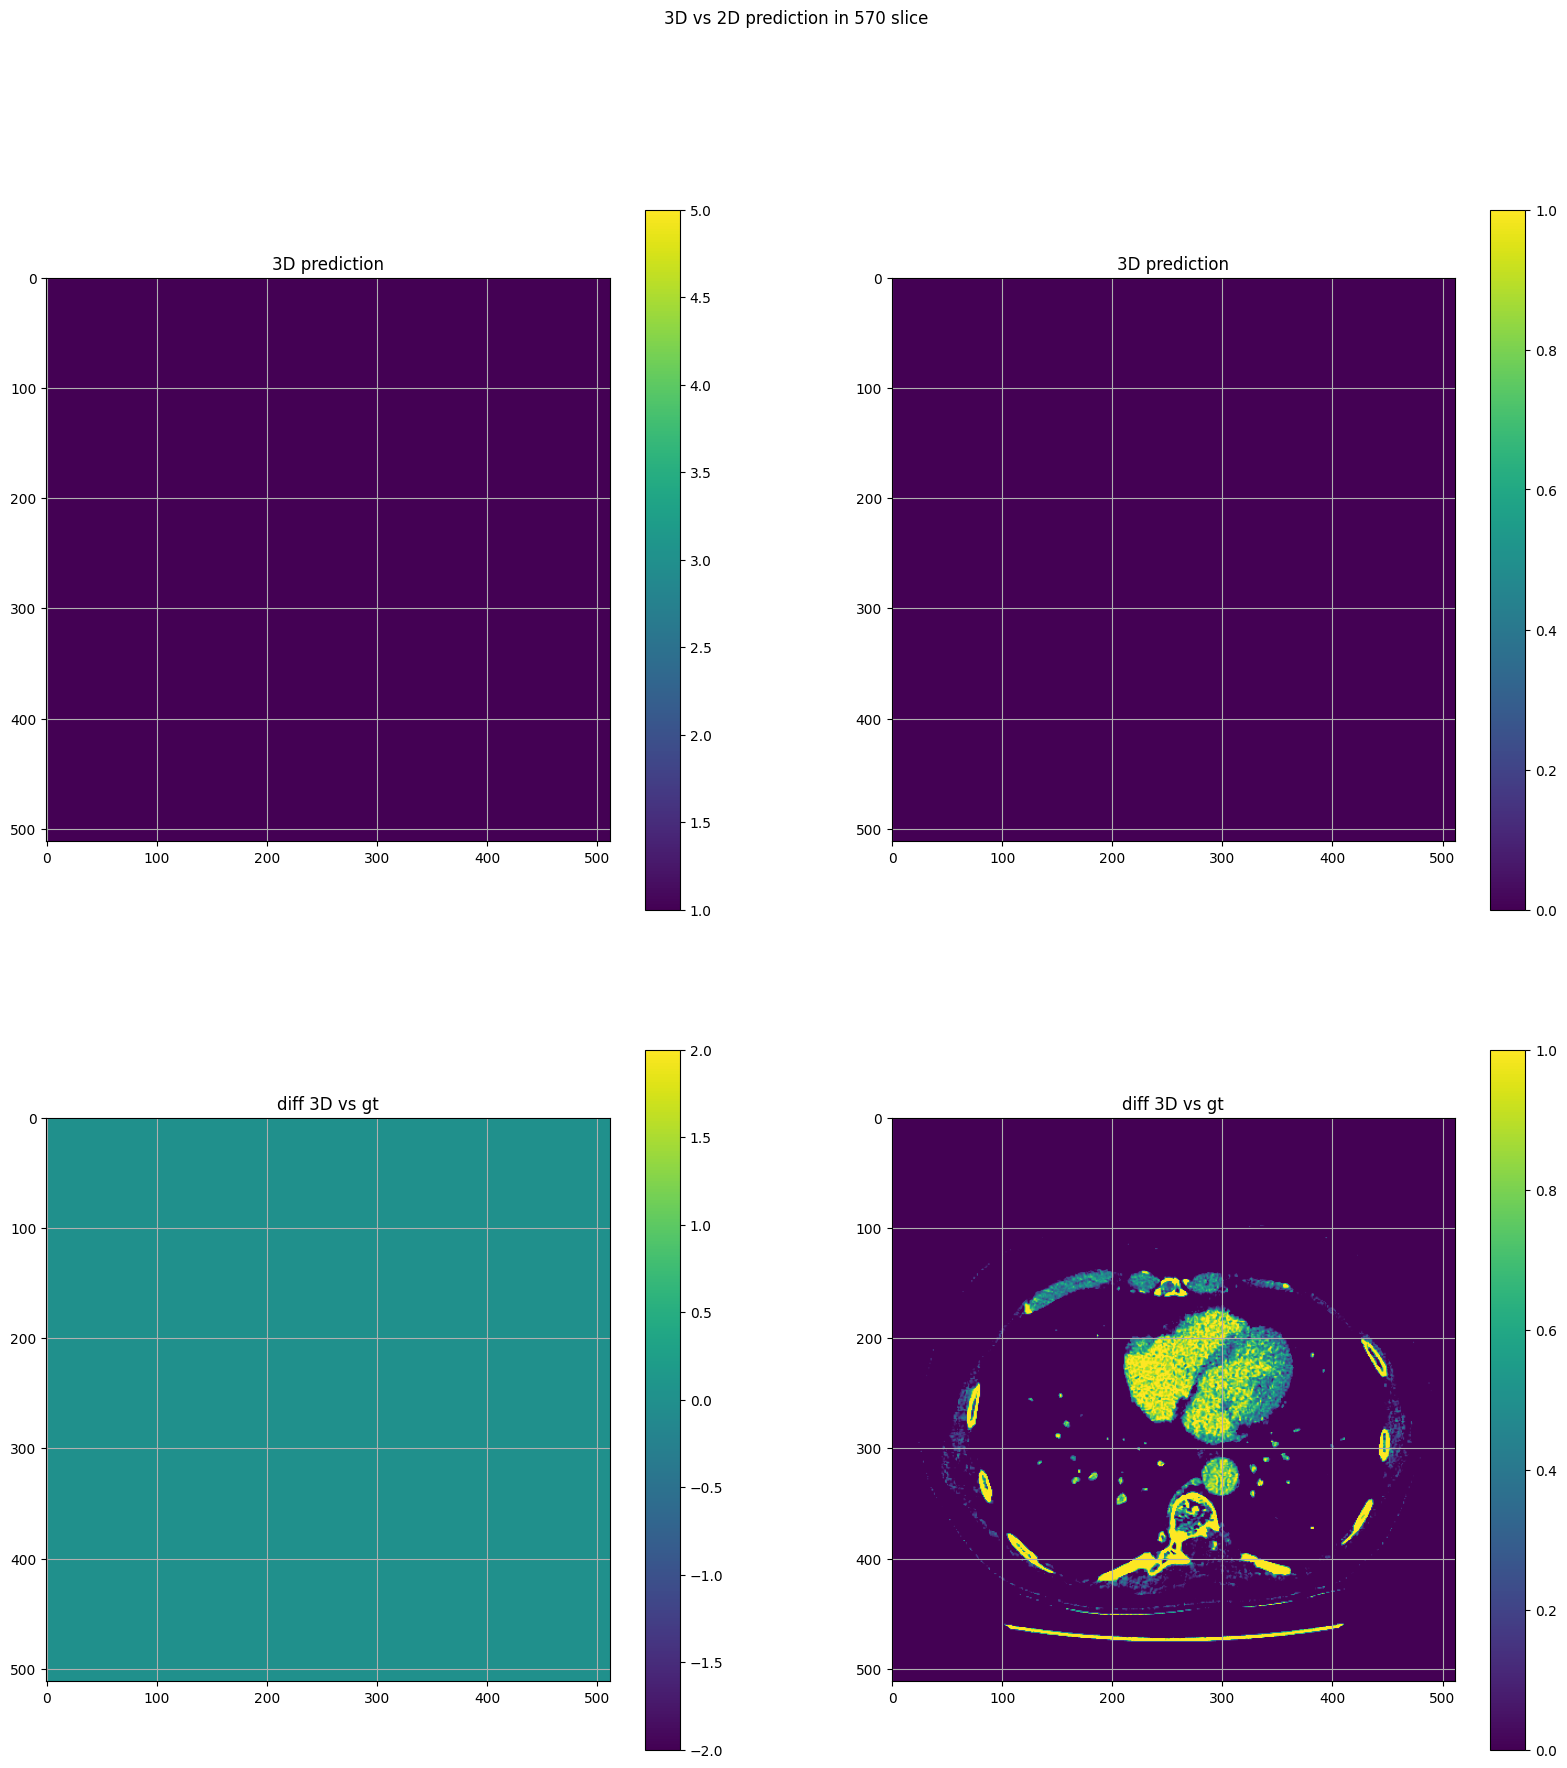

In [63]:
s=570
#for s in tqdm(range(350,550,1)):


plt.suptitle(f"3D vs 2D prediction in {s} slice")
plt.subplot(2,2,1)
plt.title("3D prediction")
plt.imshow(result_3d[s],vmin=1,vmax=5)
plt.colorbar()
plt.grid()


plt.suptitle(f"3D vs 2D prediction in {s} slice")
plt.subplot(2,2,2)
plt.title("3D prediction")
plt.imshow(binary_result_3d[s],vmin=0,vmax=1)
plt.colorbar()
plt.grid()



plt.subplot(2,2,3)
plt.title("diff 3D vs gt")
plt.imshow(gt[s]-2*binary_result_3d[s],vmin=-2,vmax=2)
plt.colorbar()
plt.grid()

plt.subplot(2,2,4)
plt.title("diff 3D vs gt")
plt.imshow(volume[s])
plt.colorbar()
plt.grid()
